# Autoencoder : Noise 데이터 복원하기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

### Noise 생성 (가우시안 Noise)

In [2]:
# 이미지에 가우스 노이즈를 더해주는 함수

def gaussian_noise(x,scale=0.8):

  gaussian_data_x = x+np.random.normal(loc=0,scale=scale,size=x.shape)
  gaussian_data_x = np.clip(gaussian_data_x,0,1)
  gaussian_data_x = torch.tensor(gaussian_data_x)
  gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)

  return gaussian_data_x

train_data = MNIST(root='./',train=True,download=True,transform=ToTensor())
test_data = MNIST(root='./',train=False,download=True,transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 78929484.37it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105795365.79it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21299129.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4844997.14it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



<ipython-input-2-223b521a24f2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


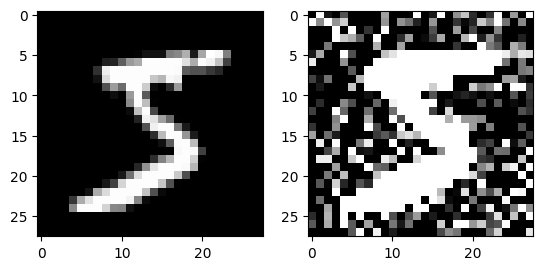

In [8]:
img = train_data.data[0]
noise_img = gaussian_noise(img)

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')

plt.subplot(1,2,2)
plt.imshow(noise_img,cmap='gray')

In [10]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):

  def __init__(self):

    self.mnist = MNIST(root='./',train=True,download=True,transform=ToTensor())
    self.data = []

    for tmp in range(len(self.mnist)):
      noise_input = gaussian_noise(self.mnist.data[tmp])
      input_tensor = torch.tensor(noise_input)
      self.data.append(torch.unsqueeze(input_tensor,dim=0))

  def __len__(self):
    return len(self.data)

  def __getitem__(self,i):
    # 노이즈 데이터
    data = self.data[i]
    # 원본 데이터
    label = self.mnist.data[i]/255

    return data,label

In [16]:
import torch.nn as nn

# 합성곱 신경망 기반 Autoencoder
# Conv2D - ReLU - Conv2D - ReLU 가 기본 블럭

class BasicBlock(nn.Module):

  def __init__(self,in_channel,out_channel,hidden_dim):
    super(BasicBlock,self).__init__()

    # in_channle로 들어오고 hidden_dim 으로 나감
    self.conv1 = nn.Conv2d(in_channel,
                           hidden_dim,
                           kernel_size=3,
                           padding=1)

    self.conv2 = nn.Conv2d(hidden_dim,
                           out_channel,
                           kernel_size=3,
                           padding=1)

    self.relu = nn.ReLU()

  def forward(self,x):

    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)

    return x

In [17]:
class Encoder(nn.Module):

  def __init__(self):
    super(Encoder,self).__init__()

    # in_channel = 1, hidden_dim = 16
    # hidden_dim = 16, out_channel = 16
    self.conv1 = BasicBlock(1,16,16)

    # in_channel = 16, hidden_dim = 8
    # hidden_dim = 8, out_channel = 8
    self.conv2 = BasicBlock(16,8,8)

    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)

  def forward(self,x):

    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)

    return x

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
from torchsummary import summary

encoder = Encoder()

In [27]:
summary(encoder.to(device),input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
        BasicBlock-5           [-1, 16, 28, 28]               0
         AvgPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7            [-1, 8, 14, 14]           1,160
              ReLU-8            [-1, 8, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             584
             ReLU-10            [-1, 8, 14, 14]               0
       BasicBlock-11            [-1, 8, 14, 14]               0
        AvgPool2d-12              [-1, 8, 7, 7]               0
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
-----------------------------------

In [ ]:
nn.ConvTranspose2d (kernerl = 2, stride=2)
(SIZE - 1) * stride - 2*padding + kernel_size
(7-1) * 2 - 2*0 + 2 = 14

In [22]:
class Decoder(nn.Module):

  def __init__(self):
      super(Decoder, self).__init__()

      self.conv1 = BasicBlock(8,8,8)
      self.conv2 = BasicBlock(8,16,16)
      self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

      self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
      self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)

  def forward(self,x):

    x = self.conv1(x) # 8,7,7
    x = self.upsample1(x)
    x = self.conv2(x)
    x = self.upsample2(x)
    x = self.conv3(x) # 1,28,28

    return x

In [29]:
decoder = Decoder()

summary(decoder.to(device),input_size=(8,7,7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 7, 7]             584
              ReLU-2              [-1, 8, 7, 7]               0
            Conv2d-3              [-1, 8, 7, 7]             584
              ReLU-4              [-1, 8, 7, 7]               0
        BasicBlock-5              [-1, 8, 7, 7]               0
   ConvTranspose2d-6            [-1, 8, 14, 14]             264
            Conv2d-7           [-1, 16, 14, 14]           1,168
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
       BasicBlock-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12           [-1, 16, 28, 28]           1,040
           Conv2d-13            [-1, 1, 28, 28]             145
Total params: 6,105
Trainable params: 6

In [30]:
class Model(nn.Module):
  def __init__(self):
      super(Model,self).__init__()

      self.encoder = Encoder()
      self.decoder = Decoder()

  def forward(self,x):

    x = self.encoder(x)
    x = self.decoder(x) # 1,28,28
    x = torch.squeeze(x) # 28,28

    return x

In [31]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


In [36]:
trainset = Denoising()
train_loader = DataLoader(trainset,batch_size=32)

model = Model().to(device)
optim = Adam(model.parameters(),lr=1e-3)

<ipython-input-2-223b521a24f2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-10-5501c107cdf1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noise_input)


In [37]:
from tqdm import tqdm

for epoch in range(20):

  # data : 노이즈 데이터
  # label : 원본 데이터
  for data,label in tqdm(train_loader):
    optim.zero_grad()
    pred = model(data.to(device))

    # print("label : ",label)
                        # 배치값 제외 후 비교
    loss = nn.MSELoss()(torch.squeeze(pred),label.to(device))

    loss.backward()

    optim.step()
  print("epoch : ",epoch+1," loss : ",loss.item())

100%|██████████| 1875/1875 [00:08<00:00, 218.96it/s]


epoch :  1  loss :  0.012910719960927963


100%|██████████| 1875/1875 [00:08<00:00, 220.74it/s]


epoch :  2  loss :  0.011364469304680824


100%|██████████| 1875/1875 [00:08<00:00, 221.02it/s]


epoch :  3  loss :  0.010700255632400513


100%|██████████| 1875/1875 [00:08<00:00, 222.10it/s]


epoch :  4  loss :  0.010192801244556904


100%|██████████| 1875/1875 [00:08<00:00, 222.49it/s]


epoch :  5  loss :  0.010181925259530544


100%|██████████| 1875/1875 [00:08<00:00, 208.90it/s]


epoch :  6  loss :  0.010046785697340965


100%|██████████| 1875/1875 [00:08<00:00, 217.76it/s]


epoch :  7  loss :  0.009911741130053997


100%|██████████| 1875/1875 [00:08<00:00, 219.55it/s]


epoch :  8  loss :  0.009818406775593758


100%|██████████| 1875/1875 [00:08<00:00, 223.89it/s]


epoch :  9  loss :  0.009757498279213905


100%|██████████| 1875/1875 [00:08<00:00, 216.19it/s]


epoch :  10  loss :  0.009420269168913364


100%|██████████| 1875/1875 [00:08<00:00, 220.59it/s]


epoch :  11  loss :  0.008677345700562


100%|██████████| 1875/1875 [00:08<00:00, 218.84it/s]


epoch :  12  loss :  0.008182264864444733


100%|██████████| 1875/1875 [00:08<00:00, 218.45it/s]


epoch :  13  loss :  0.008028604090213776


100%|██████████| 1875/1875 [00:08<00:00, 222.22it/s]


epoch :  14  loss :  0.007879633456468582


100%|██████████| 1875/1875 [00:08<00:00, 222.65it/s]


epoch :  15  loss :  0.007866100408136845


100%|██████████| 1875/1875 [00:08<00:00, 224.38it/s]


epoch :  16  loss :  0.00786562915891409


100%|██████████| 1875/1875 [00:08<00:00, 223.50it/s]


epoch :  17  loss :  0.007881703786551952


100%|██████████| 1875/1875 [00:08<00:00, 220.37it/s]


epoch :  18  loss :  0.007930507883429527


100%|██████████| 1875/1875 [00:08<00:00, 222.60it/s]


epoch :  19  loss :  0.007882870733737946


100%|██████████| 1875/1875 [00:08<00:00, 224.06it/s]

epoch :  20  loss :  0.007864410057663918


<ipython-input-2-223b521a24f2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


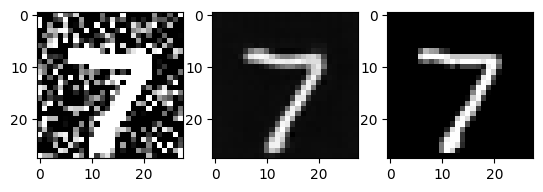

In [39]:
model.cpu()
model.eval()

with torch.no_grad():
  img = test_data.data[0]
  noise = gaussian_noise(img) #28,28

  input = torch.unsqueeze(noise,dim=0)
  input.type(torch.FloatTensor)
  input.to(device)
  input = torch.unsqueeze(input,dim=0)

  plt.subplot(1,3,1)
  plt.imshow(torch.squeeze(noise),cmap='gray')
  plt.subplot(1,3,2)
  plt.imshow(torch.squeeze(model(input)),cmap='gray')
  plt.subplot(1,3,3)
  plt.imshow(torch.squeeze(img),cmap='gray')